# Metrics Heatmap

<a href="https://colab.research.google.com/github/netdata/netdata-community/blob/main/netdata-agent-api/netdata-pandas/metrics_heatmap.ipynb" target="_blank"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we will use the [netdata-pandas](https://github.com/netdata/netdata-pandas) Python package to pull some data from some demo Netdata servers and make some pretty looking heatmaps, because we all love a good heatmap don't we. 

**Note**: you can click the "Open in Colab" button above to open this notebook in [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) where you can just get going with it without having to set up python enviornments or any messy stuff like that.

In [1]:
# if you need to, uncomment below to install netdata-pandas and seaborn packages
#!pip install plotly==4.14.1 netdata-pandas==0.0.33 scikit-learn==0.23.2

In [2]:
import numpy as np
import pandas as pd
from netdata_pandas.data import get_data
import plotly.express as px
from sklearn.cluster import KMeans, AgglomerativeClustering

Lets pull some data for the last 15 minutes.

In [3]:
# inputs
hosts = ['london.my-netdata.io']
charts_regex = 'system.*'
before = 0
after = -60*15
resample_freq = '10s'

In [4]:
# get the data
df_raw = get_data(hosts=hosts, charts_regex=charts_regex, after=after, before=before, index_as_datetime=True)
print(df_raw.shape)
df_raw.head()

(901, 72)


,system.active_processes|active,system.cpu|guest,system.cpu|guest_nice,system.cpu|iowait,system.cpu|irq,system.cpu|nice,system.cpu|softirq,system.cpu|steal,system.cpu|system,system.cpu|user,...,system.softirqs|RCU,system.softirqs|SCHED,system.softirqs|TASKLET,system.softirqs|TIMER,system.softnet_stat|dropped,system.softnet_stat|flow_limit_count,system.softnet_stat|processed,system.softnet_stat|received_rps,system.softnet_stat|squeezed,system.uptime|uptime
time_idx,,,,,,,,,,,,,,,,,,,,,
2020-12-17 22:07:18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-12-17 22:07:19,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,2.948403,1.228501,0.491401,...,102.84023,97.19177,18.223810,129.84048,0.0,0.0,50.79238,0.0,0.0,67378840.0
2020-12-17 22:07:20,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,4.187192,1.231527,0.492611,...,87.77395,80.74703,10.683926,110.78337,0.0,0.0,30.05003,0.0,0.0,67378840.0
2020-12-17 22:07:21,210.0,0.0,0.0,0.0,0.0,0.0,0.240964,4.578313,1.686747,0.963855,...,89.84490,89.91068,19.429600,122.99334,0.0,0.0,52.55451,0.0,0.0,67378850.0
2020-12-17 22:07:22,210.0,0.0,0.0,0.0,0.0,0.0,0.000000,5.528846,1.923077,0.961538,...,129.03425,121.01417,31.174260,170.10780,0.0,0.0,88.53752,0.0,0.0,67378850.0


## Heatmaps!

In [5]:
# lets resample to 10 sec frequency
df = df_raw.resample(resample_freq).mean()

# lets min-max normalize our data so metrics can be compared on a heatmap
df=(df-df.min())/(df.max()-df.min())

# drop na cols
df = df.dropna(how='all', axis=1)

# lets sort cols by their std to try make heatmap prettier
df = df[df.std().sort_values(ascending=False).index]

print(df.shape)
df.head(10)

(91, 46)


,system.processes|blocked,system.entropy|entropy,system.uptime|uptime,system.ram|cached,system.load|load15,system.load|load5,system.ipv6|received,system.ram|free,system.cpu|iowait,system.ram|used,...,system.cpu|softirq,system.cpu|user,system.softirqs|TASKLET,system.io|out,system.pgpgio|out,system.forks|started,system.interrupts|virtio0-input.0_25,system.ram|buffers,system.net|received,system.softnet_stat|squeezed
time_idx,,,,,,,,,,,,,,,,,,,,,
2020-12-17 22:07:10,1.0,0.398070,0.000000,0.002811,NaN,NaN,0.947772,0.758362,0.00000,0.366011,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000,0.0
2020-12-17 22:07:20,1.0,0.417370,0.010012,0.000000,0.000000,0.111111,0.545691,0.794608,0.00000,0.335004,...,0.177312,0.446098,0.155188,0.746640,0.747054,0.140145,0.156029,0.0,0.689987,0.0
2020-12-17 22:07:30,1.0,0.451950,0.021137,0.014857,0.000000,0.101852,0.779905,0.825930,0.00000,0.305610,...,0.271108,0.566496,0.105708,0.774806,0.775360,0.306872,0.100882,0.0,0.526903,0.0
2020-12-17 22:07:40,1.0,0.486932,0.032262,0.027808,0.250000,0.351852,0.580304,0.880786,0.47619,0.256056,...,0.360535,0.333687,0.222729,0.802678,0.802938,0.140201,0.223830,0.0,0.640076,0.2
2020-12-17 22:07:50,0.0,0.520306,0.043387,0.035136,0.625000,0.675926,0.599034,0.858671,0.00000,0.273971,...,0.183250,0.500682,0.242878,0.781630,0.781944,0.028862,0.231054,0.0,0.686508,0.0
2020-12-17 22:08:00,1.0,0.554483,0.054512,0.046379,0.760501,0.805630,0.687275,0.938077,0.00000,0.203513,...,0.275106,0.497418,0.197121,0.550097,0.551006,0.029749,0.194120,0.0,0.707470,0.2
2020-12-17 22:08:10,1.0,0.589867,0.065637,0.062040,1.000000,1.000000,0.620545,0.918101,0.00000,0.218376,...,0.090947,0.619380,0.156916,0.697436,0.697966,0.029214,0.155898,0.0,0.612646,0.0
2020-12-17 22:08:20,1.0,0.625251,0.076761,0.070171,1.000000,1.000000,0.672076,0.971821,0.00000,0.170593,...,0.182345,0.661136,0.286272,0.844775,0.844927,0.029217,0.288203,0.0,0.795528,0.0
2020-12-17 22:08:30,1.0,0.659429,0.087886,0.083121,1.000000,0.944444,0.600526,0.916961,0.00000,0.215989,...,0.183934,0.693768,0.130601,0.562653,0.563147,0.029252,0.124214,0.0,0.613098,0.0


In [6]:
# lets cluster the columns to show similar metrics next to each other on the heatmap
#clustering = KMeans(n_clusters=int(round(len(df.columns)*0.2,0))).fit(df.fillna(0).transpose().values)
clustering = AgglomerativeClustering(n_clusters=int(round(len(df.columns)*0.2,0))).fit(df.fillna(0).transpose().values)

# get order of cols from the cluster labels
cols_sorted = pd.DataFrame(
    zip(df.columns, clustering.labels_), 
    columns=['metric', 'cluster']
    ).sort_values('cluster')['metric'].values.tolist()

# re-order cols
df = df[cols_sorted]

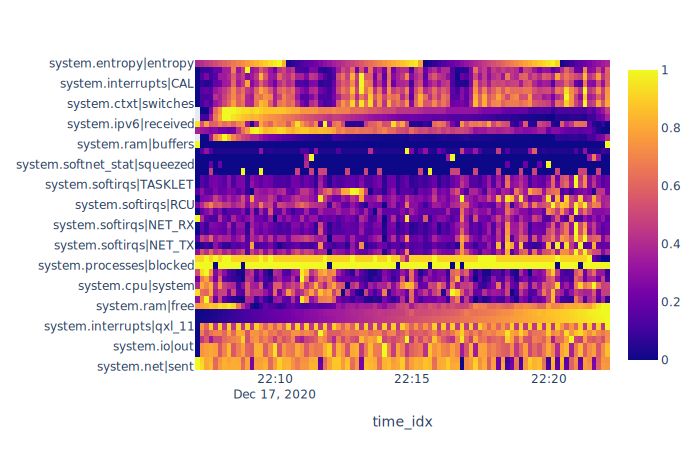

In [7]:
# now plot our heatmap
fig = px.imshow(df.transpose())
fig.update_layout(
    autosize=False,
    width=1000,
    height=1200)
# fig.show() # for interactive
fig.show("svg") # static svg so can be displayed on github, best use above line